# Actividad evaluable del módulo 4: Clasificación mediante CNN del conjunto de datos FashionMNIST

Ahora que hemos aprendido a utilizar las capas convolucionales, vamos a enfrentarnos a un conjunto de datos nuevo y más complejo: [FashionMNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist). Tiene un formato similar al conjunto de datos MNIST, pero contiene imágenes de diferentes prendas de ropa. 

En esta actividad, deberá desarrollar un clasificador CNN que implemente **al menos 2 capas** convolucionales.

Más abajo, encontrará una plantilla con el código inicial. Le animamos a reutilizar código que haya escrito o visto en cuadernos anteriores.



In [2]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Estas transformaciones sucederán en todos los puntos de datos. En este ejemplo,
# queremos convertir cada punto de datos en un tensor y realizar una normalización
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# Fíjese en que FashionMNIST también está integrado en PyTorch
fashion_mnist_train = torchvision.datasets.FashionMNIST('', train=True, transform =transform, download=True)

# Dividiremos el conjunto de entrenamiento en entrenamiento y validación

fashion_mnist_train, fashion_mnist_val = torch.utils.data.random_split(fashion_mnist_train, [int(np.floor(len(fashion_mnist_train)*0.75)), int(np.ceil(len(fashion_mnist_train)*0.25))])

fashion_mnist_test = torchvision.datasets.FashionMNIST('', train=False, transform = transform, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw



In [4]:
# Crearemos DataLoaders igual que antes, con un tamaño de lotes de 100
batch_size = 100
dataloaders = {'train': DataLoader(fashion_mnist_train, batch_size=batch_size),
               'val': DataLoader(fashion_mnist_val, batch_size=batch_size),
               'test': DataLoader(fashion_mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(fashion_mnist_train),
                 'val': len(fashion_mnist_val),
                 'test': len(fashion_mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


## Visualización

Antes de seguir avanzando, nos interesa visualizar los puntos de datos del conjunto. De manera similar al conjunto de MNIST, en este tenemos 10 clases de objetos diferentes, marcadas con las siguientes etiquetas:

* 0 - Camiseta/top
* 1 - Pantalón
* 2 - Jersey
* 3 - Vestido
* 4 - Abrigo
* 5 - Sandalia
* 6 - Camisa
* 7 - Zapatilla
* 8 - Bolso
* 9 - Botín

Utilizando la función que aparece más abajo, podemos ver algunas de las imágenes de cada clase con las que trabajaremos. Para obtener más información sobre el conjunto de datos, acceda a este [enlace](https://www.kaggle.com/datasets/zalando-research/fashionmnist).

In [5]:
# Trazar una ground truth sobre los datos y autocodificar
def view_fashionmnist(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # Solo queremos ver una clase determinada
            if (labels[i] != label):
                continue
            # Trazar la ground truth
            ax = fig.add_subplot(1, count, idx)
            input = input.cpu().detach().numpy().reshape((28,28))
            ax.imshow(input, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

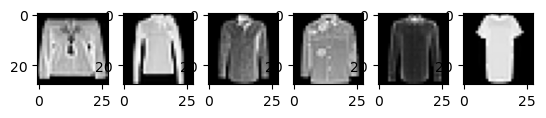

In [ ]:
# Ver 6 bolsos
view_fashionmnist(6, 6)

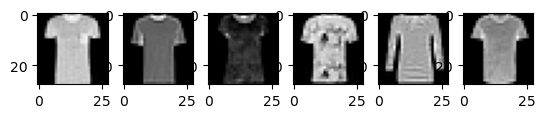

In [ ]:
view_fashionmnist(0, 6)

## Práctica

Aplique lo aprendido hasta ahora para desarrollar un clasificador CNN que implemente **al menos 2** capas convolucionales.

In [20]:
# Pista: Cree una clase llamada CNNClassifier que implemente una función "forward"

class CNNClassifier(nn.Module):
    def __init__(self, dropout=.3):
        super(CNNClassifier, self).__init__()
        # Dividir el codificador y el decodificador

        self.dropout = nn.Dropout(dropout) # dropout rate
        self.pipeline = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1), # (32, 28, 28)
            nn.BatchNorm2d(32), # https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # (32, 14, 14)

            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1), # (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # (64, 7, 7)

            nn.Flatten(),
            self.dropout,

            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            self.dropout,

            # nn.Linear(256, 128),
            # nn.ReLU(),

            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        return self.pipeline(x)


In [26]:
learning_rate = 0.0015
num_epochs = 10

model = CNNClassifier().to(device)
print(model)

CNNClassifier(
  (dropout): Dropout(p=0.3, inplace=False)
  (pipeline): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.3, inplace=False)
    (10): Linear(in_features=3136, out_features=128, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [27]:
# Pista: Intente reutilizar una de las funciones de entrenamiento que hayamos usado: 
# Hecho!

def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Los mejores pesos se deben guardar por separado
    best_acc = 0.0
    best_epoch = 0

     # Cada ciclo tiene una fase de entrenamiento, una de validación y una de prueba
    phases = ['train', 'val', 'test']
    
    # Hacer un seguimiento de la evolución de la pérdida y la precisión durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en el modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en el modo de evaluación

            running_loss = 0.0
            running_corrects = 0

            # Iterar con los datos
            for inputs, labels in dataloaders[phase]:
                # No hace falta alisar los inputs
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Poner a 0 los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Hacer una copia profunda del modelo si se ha alcanzado la mejor precisión
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    
    return model, training_curves

In [28]:
# Pérdida y optimizador
criterion = nn.CrossEntropyLoss() # Utilizar CrossEntropyLoss para la clasificación
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Entrenar el modelo y guardar los resultados de entrenamiento
model, training_curves = train_classification_model(model, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.4802 Acc: 0.8250
val   Loss: 0.3194 Acc: 0.8807
test  Loss: 0.3304 Acc: 0.8794

Epoch 2/10
----------
train Loss: 0.3375 Acc: 0.8770
val   Loss: 0.2868 Acc: 0.8929
test  Loss: 0.3012 Acc: 0.8891

Epoch 3/10
----------
train Loss: 0.2931 Acc: 0.8931
val   Loss: 0.2616 Acc: 0.9025
test  Loss: 0.2743 Acc: 0.8982

Epoch 4/10
----------
train Loss: 0.2689 Acc: 0.9009
val   Loss: 0.2435 Acc: 0.9117
test  Loss: 0.2570 Acc: 0.9053

Epoch 5/10
----------
train Loss: 0.2457 Acc: 0.9101
val   Loss: 0.2581 Acc: 0.9039
test  Loss: 0.2716 Acc: 0.8986

Epoch 6/10
----------
train Loss: 0.2291 Acc: 0.9149
val   Loss: 0.2335 Acc: 0.9151
test  Loss: 0.2461 Acc: 0.9087

Epoch 7/10
----------
train Loss: 0.2145 Acc: 0.9195
val   Loss: 0.2206 Acc: 0.9193
test  Loss: 0.2416 Acc: 0.9122

Epoch 8/10
----------
train Loss: 0.2008 Acc: 0.9245
val   Loss: 0.2220 Acc: 0.9200
test  Loss: 0.2375 Acc: 0.9129

Epoch 9/10
----------
train Loss: 0.1880 Acc: 0.9288
val   Loss: 0.2150

### Visualizar las curvas de entrenamiento y los resultados

In [29]:
# Estas funciones de utilidad sirven para trazar los resultados
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Configurar el modelo en modo evaluación
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    
    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


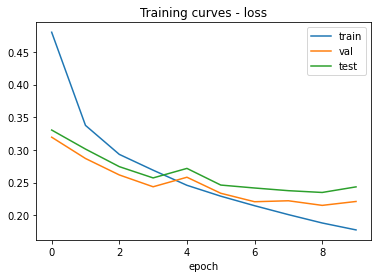

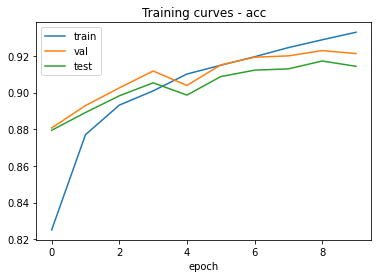

In [30]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

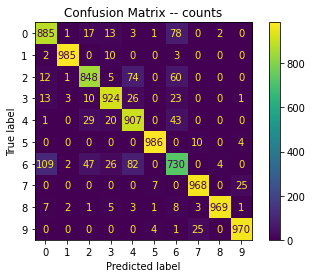

In [31]:
res = plot_cm(model, device, dataloaders, phase='test')

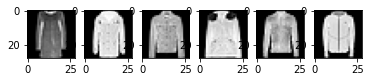

In [32]:
# Ver 1 zapatilla
view_fashionmnist(4, 6)

* 0 - Camiseta/top
* 1 - Pantalón
* 2 - Jersey
* 3 - Vestido
* 4 - Abrigo
* 5 - Sandalia
* 6 - Camisa
* 7 - Zapatilla
* 8 - Bolso
* 9 - Botín

## Conclusiones

Ahora que hemos implementado la red, debemos examinar los resultados.

¿Qué clase de objeto se clasifica incorrectamente más a menudo?¿Qué etiqueta incorrecta se le suele asignar?
- La Camisa (6) es confundida con la Camiseta/Top (0) mas a menudo

Intente también volver a entrenar su red incluyendo el *dropout*. ¿Mejora el rendimiento o hay algún cambio reseñable en la capacidad de generalización del modelo?¿El objeto que más a menudo se clasifica erróneamente sigue siendo el mismo que antes de introducir el *dropout*?
- El rendimiento mejora muy levemente (de 0.916 a 0.922)
- El objeto que mas se clasifica erroneamente sigue siendo el mismo